# IMG/VR 4.1 NCLDV FastANI

This analysis starts with the high quality fraction of the [IMG/VR 4.1](https://genome.jgi.doe.gov/portal/IMG_VR/IMG_VR.home.html) :

- IMG_VR_2022-09-20_7.1 - IMG/VR v4.1  (bugfix UViG table & protein fasta) - high-confidence genomes only

Please cite :

>Antonio Pedro Camargo, Stephen Nayfach, I-Min A. Chen, Krishnaveni Palaniappan, Anna Ratner, Ken Chu, Stephan J. Ritter, T.B.K. Reddy, Supratim Mukherjee, Frederik Schulz, Lee Call, Russell Y. Neches, Tanja Woyke, Natalia N. Ivanova, Emiley A. Eloe-Fadrosh, Nikos C. Kyrpides and Simon Roux. **IMG/VR v4: an expanded database of uncultivated virus genomes within a framework of extensive functional, taxonomic, and ecological metadata.** _Nucleic Acids Research_ 51, no. D1 (2023): D733-D743. [\[doi\]](https://doi.org/10.1093/nar/gkac1037)



In [2]:
%config InlineBackend.figure_format = 'retina'

import pandas
import polars
import seaborn
import matplotlib
import gzip
import pysam
import os
import networkx
import random
import pyprind
from Bio import SeqIO
from numpy import zeros
from scipy.cluster.hierarchy import single, fcluster
from scipy.spatial.distance import squareform
from collections import defaultdict, Counter
from itertools import combinations, product
from pathlib import Path
from copy import deepcopy
from snakemake.io import expand, glob_wildcards
from hmm_profile import reader as hmmreader
from hmm_profile import writer as hmmwriter

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Load IMG/VR 4.0, select _Nucleocytoviricota_ data

In [7]:
imgvr = polars.read_csv( 'data/imgvr/IMG_VR_2022-12-19_7.1/IMGVR_all_Sequence_information-high_confidence.tsv',
                         separator='\t', infer_schema_length=10000 ) \
              .rename( { 'Coordinates (\'whole\' if the UViG is the entire contig)' : 'coordinates' } )

taxonomy = polars.from_records( [ { 't'+str(n) : name 
                                     for n,name in enumerate(str(x).split(';')) }
                                  for x in imgvr['Taxonomic classification'] ] )

imgvr = polars.concat( [imgvr, taxonomy], how='horizontal' )

ncldvs = imgvr.filter( polars.col('t2') == 'p__Nucleocytoviricota' )

ncldv_uvigs = list( ncldvs[ 'UVIG' ] )

ncldvs.head()

UVIG,Taxon_oid,Scaffold_oid,coordinates,Ecosystem classification,vOTU,Length,Topology,geNomad score,Confidence,Estimated completeness,Estimated contamination,MIUViG quality,Gene content (total genes;cds;tRNA;geNomad marker),Taxonomic classification,Taxonomic classification method,Host taxonomy prediction,Host prediction method,Sequence origin (doi),t0,t1,t2,t3,t4,t5,t6,t7
str,i64,str,str,str,str,i64,str,f64,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""IMGVR_UViG_330…",3300002123,"""C687J26634_100…","""298-4658""","""Environmental;…","""vOTU_00000419""",4361,"""Provirus""",0.5478,"""High-confidenc…","""NA""",0.0,"""Unsure""","""10;10;0;""","""r__Varidnaviri…","""vOTU consensus…",""";;;;;;""",null,"""Inoviruses (10…","""r__Varidnaviri…","""k__Bamfordvira…","""p__Nucleocytov…","""c__Megaviricet…","""o__Imiterviral…","""""","""""",""""""
"""IMGVR_UViG_330…",3300002530,"""C687J35503_100…","""2491-6928""","""Environmental;…","""vOTU_00000419""",4438,"""Provirus""",0.6632,"""High-confidenc…","""NA""",0.0,"""Unsure""","""11;11;0;""","""r__Varidnaviri…","""vOTU consensus…",""";;;;;;""",null,"""Inoviruses (10…","""r__Varidnaviri…","""k__Bamfordvira…","""p__Nucleocytov…","""c__Megaviricet…","""o__Imiterviral…","""""","""""",""""""
"""IMGVR_UViG_330…",3300009503,"""Ga0123519_1001…","""9657-13486""","""Environmental;…","""vOTU_00003617""",3830,"""Provirus""",0.396,"""High-confidenc…","""NA""",0.0,"""Unsure""","""10;10;0;1""","""r__Varidnaviri…","""vOTU consensus…",""";;;;;;""",null,"""Inoviruses (10…","""r__Varidnaviri…","""k__Bamfordvira…","""p__Nucleocytov…","""c__Megaviricet…","""o__Imiterviral…","""""","""""",""""""
"""IMGVR_UViG_330…",3300025001,"""Ga0209618_1001…","""2026-5594""","""Environmental;…","""vOTU_00000419""",3569,"""Provirus""",0.4582,"""High-confidenc…","""NA""",0.0,"""Unsure""","""7;7;0;""","""r__Varidnaviri…","""vOTU consensus…",""";;;;;;""",null,"""Inoviruses (10…","""r__Varidnaviri…","""k__Bamfordvira…","""p__Nucleocytov…","""c__Megaviricet…","""o__Imiterviral…","""""","""""",""""""
"""IMGVR_UViG_330…",3300025002,"""Ga0209001_1000…","""87-4524""","""Environmental;…","""vOTU_00000419""",4438,"""Provirus""",0.7565,"""High-confidenc…","""NA""",0.0,"""Unsure""","""11;11;0;""","""r__Varidnaviri…","""vOTU consensus…",""";;;;;;""",null,"""Inoviruses (10…","""r__Varidnaviri…","""k__Bamfordvira…","""p__Nucleocytov…","""c__Megaviricet…","""o__Imiterviral…","""""","""""",""""""


In [14]:
imgvr_fna = 'data/imgvr/IMG_VR_2022-12-19_7.1/IMGVR_all_nucleotides-high_confidence.fna'
ncldv_dir = 'data/imgvr/ncldv_genome_batches/'
n_batches = 256

batch_handles = [ open( os.path.join( ncldv_dir,
                                      'batch_{n}.fna'.format(n=str(n)) ), 'w' )
                  for n in range( n_batches ) ]

seed = 1337

with pysam.FastaFile( imgvr_fna ) as fin :
    all_contig_names = defaultdict(list)
    for c in fin.references :
        all_contig_names[ c.rsplit('|')[0] ].append( c )
    p = pyprind.ProgBar( len(ncldv_uvigs) )
    N = 0
    for n,uvig in enumerate( ncldv_uvigs ) :
        fout = random.Random(seed+n).choice( batch_handles )
        p.update()
        for contig in all_contig_names[ uvig ] :
            N = N + 1
            fout.write( '>{contig}\n{data}\n'.format( contig=contig,
                                                      data=fin.fetch( contig ) ) )

for f in batch_handles :
    f.close()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:21


In [15]:
print( 'IMG/VR UViGs               :', imgvr.shape[0] )
print( 'Nucleocytoviricota UViGs   :', len( ncldv_uvigs ) )
print( 'IMV/VR Contigs             :', sum( [ len(c) for c in all_contig_names.values() ] ) )
print( 'Nucleocytoviricota Contigs :', N )

IMG/VR UViGs               : 5576197
Nucleocytoviricota UViGs   : 104220
IMV/VR Contigs             : 5621398
Nucleocytoviricota Contigs : 149421


(0.0, 1000000.0)

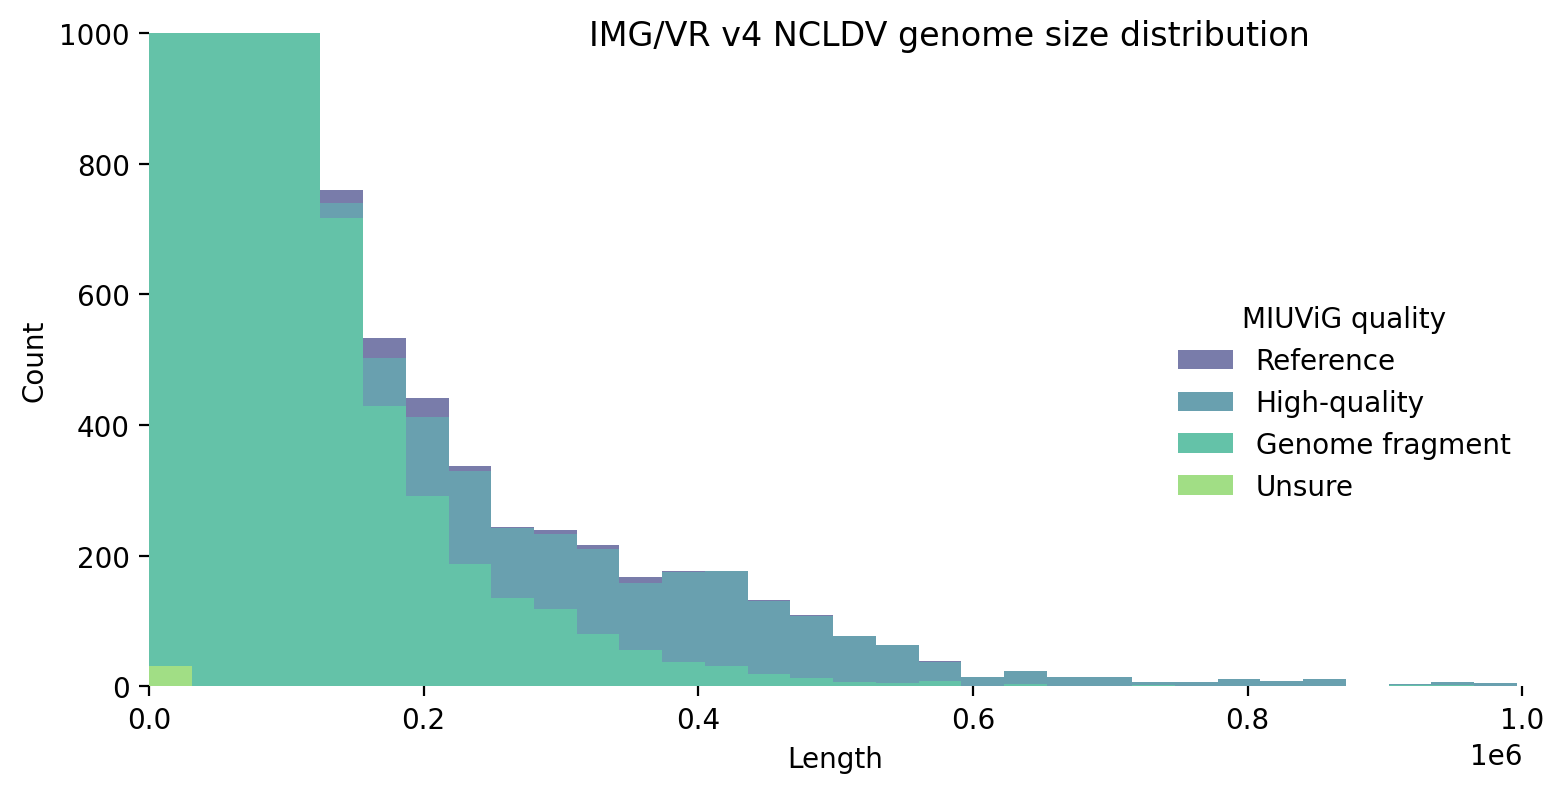

In [16]:
fraglength = 3000

g = seaborn.displot( data=ncldvs.filter( polars.col('Length') < 1000000 ),
                     x='Length', hue='MIUViG quality',
                     kind='hist', kde=False, multiple='stack',
                     hue_order=[ 'Reference', 'High-quality', 'Genome fragment', 'Unsure' ],
                     palette='viridis', alpha=0.7, bins=32,
                     linewidth=0, height=4, aspect=2 )

g.fig.suptitle('IMG/VR v4 NCLDV genome size distribution' )

seaborn.move_legend( g, 'center right', bbox_to_anchor=(0.80, 0.5) )

g.ax.spines['top'].set_visible(False)
g.ax.spines['bottom'].set_visible(False)
g.ax.spines['right'].set_visible(False)
g.ax.spines['left'].set_visible(False)
g.ax.set_ylim( 0, 1000 )
g.ax.set_xlim( 0, 1000000 )

## Load ANI results

In [4]:
ANIfile = '../kizuchi/ani/ani.tsv'

header = [ 'query', 'reference', 'ANI', 
           'bidirectional fragment mappings',
           'total query fragments' ]

fastani = polars.read_csv( '../kizuchi/ani/ani.tsv', separator='\t', has_header=False )
fastani.columns = header

# file names -> genome names
fastani = fastani.with_columns( fastani.map_rows( lambda t : Path(t[0]).stem )['map'].alias('query') )
fastani = fastani.with_columns( fastani.map_rows( lambda t : Path(t[1]).stem )['map'].alias('reference') )

# %ID -> distance
fastani = fastani.with_columns( fastani.select( 1 - polars.col('ANI') / 100 )['literal'].alias('distance') )

fastani = fastani.filter( polars.all_horizontal( polars.selectors.float().is_not_nan() ) )

fastani.head()

query,reference,ANI,bidirectional fragment mappings,total query fragments,distance
str,str,f64,i64,i64,f64
"""IMGVR_UViG_330…","""IMGVR_UViG_330…",100.0,1,1,0.0
"""IMGVR_UViG_330…","""IMGVR_UViG_330…",100.0,1,1,0.0
"""IMGVR_UViG_330…","""IMGVR_UViG_330…",100.0,1,1,0.0
"""IMGVR_UViG_330…","""IMGVR_UViG_330…",99.9611,1,1,0.000389
"""IMGVR_UViG_330…","""IMGVR_UViG_330…",98.0983,1,1,0.019017


## Select meaningful ANI hits

In [90]:
# dataset properties

fraglength  = 3000  # fastANI fragment length 
kmer        = 16    # fastANI k-mer length
min_aln     = 5     # minimum number of aligned fragments
min_ani     = 77    # minimum ANI threshold
max_ani     = 100   # maximum ANI threshold

filteredani = fastani.filter( ( polars.col('ANI') <= max_ani )
                            & ( polars.col('ANI') >= min_ani )
                            & ( polars.col('bidirectional fragment mappings') >= min_aln ) )

(77.0, 100.0)

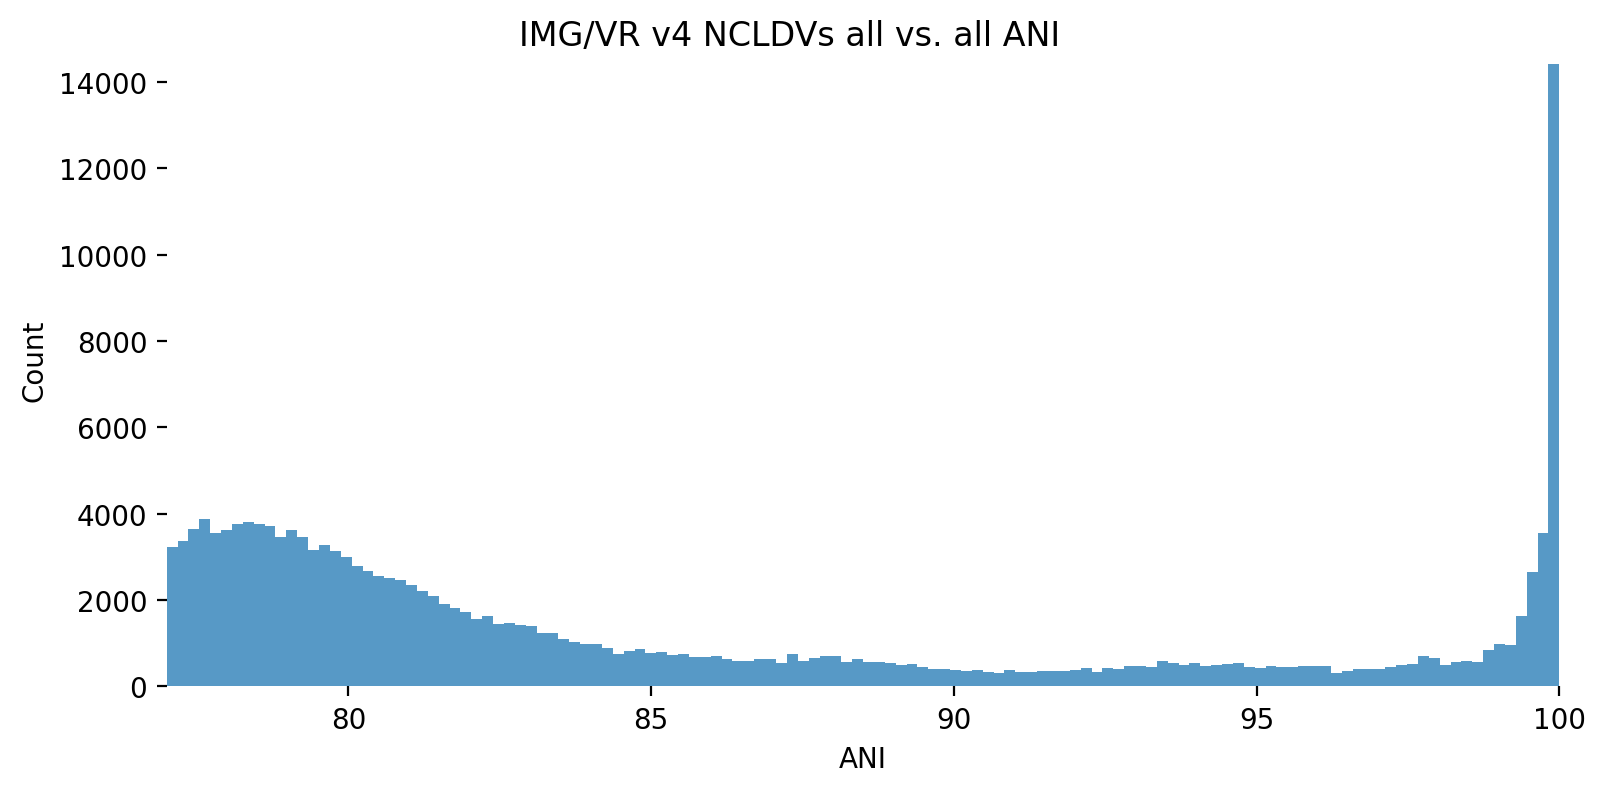

In [97]:
g = seaborn.displot( data=filteredani,
                     x='ANI', kind='hist', kde=False, bins=128,
                     fill=True, common_norm=False,
                     alpha=0.75, linewidth=0, height=4, aspect=2 )

g.fig.suptitle('IMG/VR v4 NCLDVs all vs. all ANI' )

g.ax.spines['top'].set_visible(False)
g.ax.spines['bottom'].set_visible(False)
g.ax.spines['right'].set_visible(False)
g.ax.spines['left'].set_visible(False)
#g.ax.set_ylim( 0, 1000 )
g.ax.set_xlim( min_ani, max_ani )

In [93]:
G = networkx.from_pandas_edgelist( filteredani.to_pandas(),
                                   source='query',
                                   target='reference',
                                   edge_attr='ANI' )

(0.0, 7000.0)

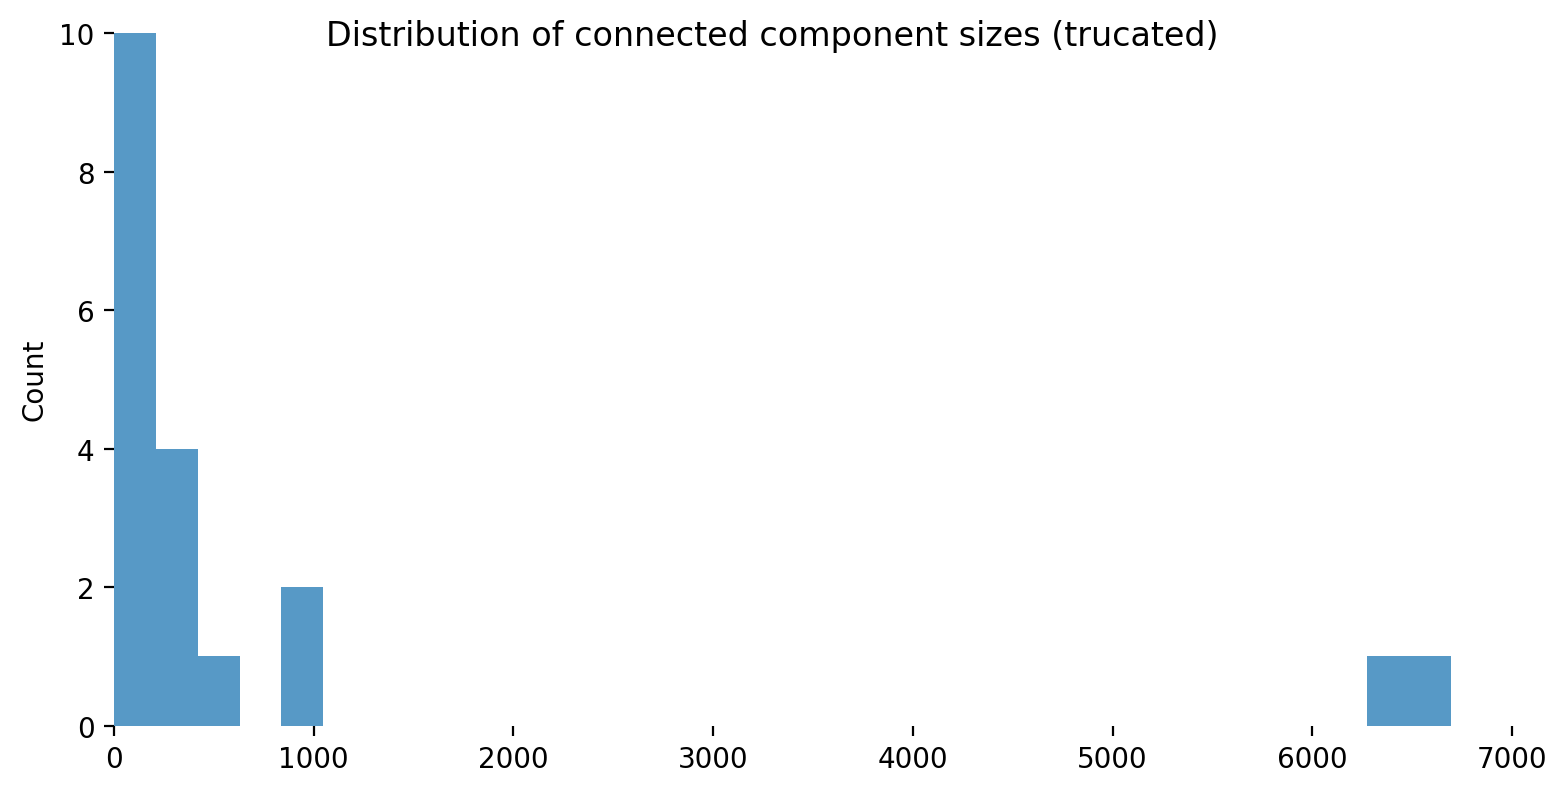

In [133]:
components = list( networkx.connected_components( G ) )

g = seaborn.displot( data=[ len(c) for c in components ],
                     kind='hist', kde=False, bins=32,
                     fill=True, common_norm=False,
                     alpha=0.75, linewidth=0, height=4, aspect=2 )

g.fig.suptitle('Distribution of connected component sizes (trucated)' )

g.ax.spines['top'].set_visible(False)
g.ax.spines['bottom'].set_visible(False)
g.ax.spines['right'].set_visible(False)
g.ax.spines['left'].set_visible(False)
g.ax.set_ylim( 0, 10 )
g.ax.set_xlim( 0, 7000 )

In [152]:
genomes = list( set( filteredani['query'] ) | set( filteredani['reference'] ) )
genome_index = { g:n for n,g in enumerate( genomes ) }

D = zeros( ( len(genomes), len(genomes) ) )
D.fill( 1.0 )

for i in range(len(genomes)) :
    D[i,i] = 0.0

for query,reference,ani,bfm,tqf,d in filteredani.iter_rows() :
    i = genome_index[ query ]
    j = genome_index[ reference ]
    D[i,j] = D[j,i] = d

p = pyprind.ProgBar( 23 )
all_clusters = {}
for T in range( 77, 100 ) :
    p.update()
    threshold = 1 - (  T / 100 )
    ani_clusters = defaultdict(list)
    for n,c in enumerate( fcluster( single( squareform(D) ),
                          threshold,
                          criterion='distance' ) ) :
        ani_clusters[c].append( genomes[n] )
    all_clusters[T] = ani_clusters

0% [#######################] 100% | ETA: 00:00:00
Total time elapsed: 00:07:11


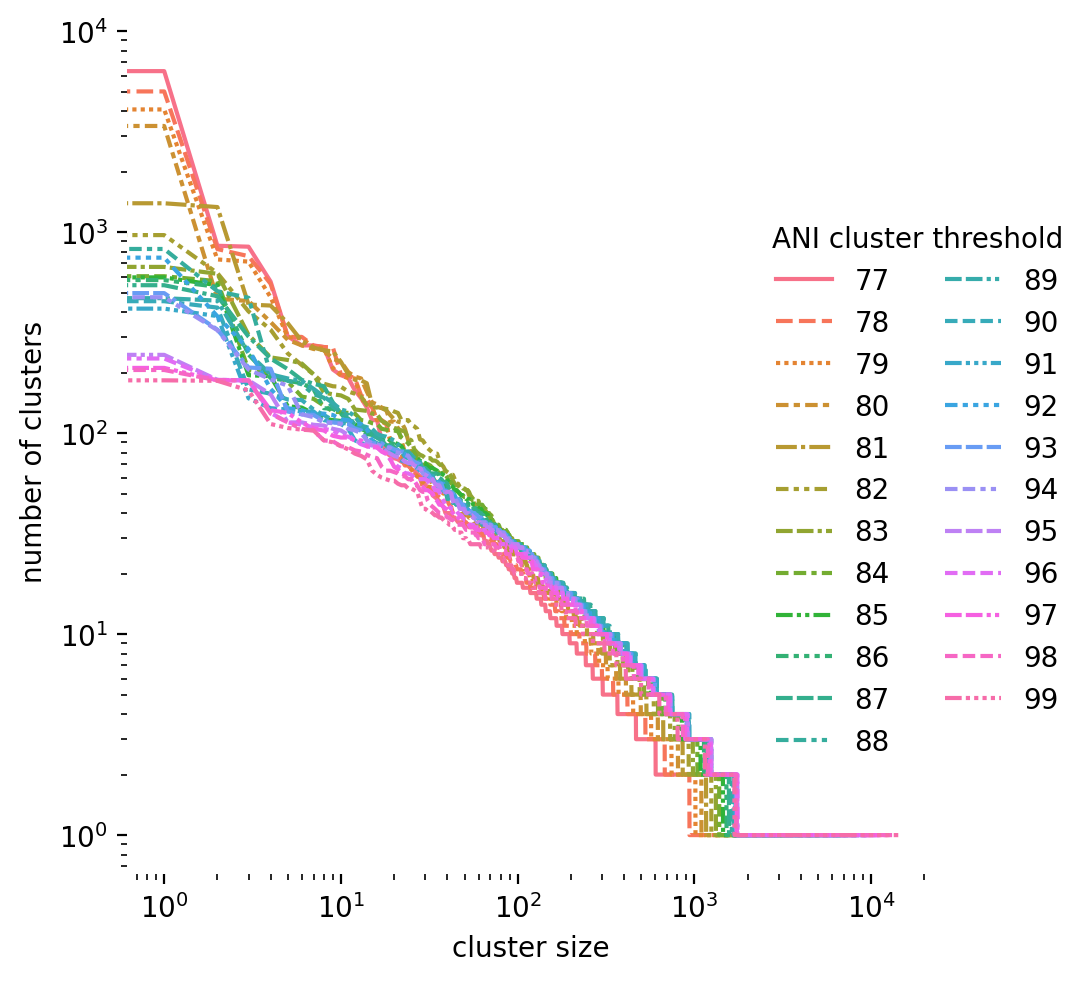

In [184]:
#fig, ax = matplotlib.pyplot.subplot( figsize=[5,5] )

g = seaborn.relplot( { T : sorted( [ len(a) for a in c.values() ], reverse=True )
                        for T,c in all_clusters.items() }, kind='line' )

g.ax.loglog()

g.set_xlabels( 'cluster size' )
g.set_ylabels( 'number of clusters' )

g.ax.spines['top'].set_visible(False)
g.ax.spines['bottom'].set_visible(False)
g.ax.spines['right'].set_visible(False)
g.ax.spines['left'].set_visible(False)

seaborn.move_legend( g, loc='center right', ncols=2, title='ANI cluster threshold' )

In [207]:
outdir = '/tmp/ani_clusters/'
for ani_cutoff,ani_clusters in all_clusters.items() :
    with open( os.path.join( outdir, 'ani_clusters_' + str(ani_cutoff) + '.txt' ), 'w' ) as f :
        for cid,cluster_genomes in ani_clusters.items() :
            f.write( '{cid}\t{genomes}\n'.format( cid=str(cid), genomes=','.join(cluster_genomes) ) )

In [28]:
# aggregate genomes into chunks
CHUNKS    = [ 'chunk_{i}'.format(i=str(i)) for i in range( 256 ) ]

HMMS_DIR  = '../kizuchi/data/hmms-enabled/'
HMM_FILES = glob_wildcards( os.path.join( HMMS_DIR, '{hmm}.hmm' ) )
HMMS      = HMM_FILES.hmm

# for each HMM...
hmmhits   = expand( '../kizuchi/hmm_hits/{chunk}_prot_tbl.txt', chunk=CHUNKS )
# ... score orthologs for each genome...
chunkfaa  = expand( '../kizuchi/proteins/{chunk}.faa', chunk=CHUNKS )
profile   = '../kizuchi/hmmdb/models.hmm'
prealign  = expand( '/tmp/scored_proteins/{hmm}.faa', hmm=HMMS )

prealignments = { Path(p).stem : { 'prealign' : p,
                                   'hits'     : [] } for p in prealign }
# use trusted cutoffs if provided
trusted_cutoffs = { m.metadata.model_name : m.metadata.trusted_cutoff
                    for m in hmmreader.read_all( open( profile ) ) }

In [27]:
faa

'.'

In [ ]:
# borrowed from CheckV
def parse_hmmsearch( path ) :
  with open(path) as f :
    names = [ 'tname', 'qacc', 'qname', 'tacc',   'eval', 
              'score', 'bias', 'beval', 'bscore', 'bbias' ]
    formats = [ str,   str,   str,   str,   float, 
                float, float, float, float, float ]
    for line in f:
      if not line.startswith( '#' ) :
        values = line.split()
        yield dict( [ ( names[i], formats[i](values[i]) ) 
                      for i in range(10) ] )

EVALUE = 1.0e-2

# load hmmer hits and protein sequences for each chunk
for tblout,faa in zip( hmmhits, chunkfaa ) :
    hits = polars.DataFrame( [ h for h in parse_hmmsearch( tblout ) ] )
    seqs = { seq.id : seq for seq in SeqIO.parse( open( faa ), 'fasta' ) }
    chunk_genomes = { name.rsplit('_',1)[0] for name in seqs.keys() }
    print( '{chunk} : found {h} hits for {p} proteins in {g} genomes'.format(
                  chunk=Path(faa).stem,
                  h=str(len(hits)),
                  p=str(len(seqs)),
                  g=str(len(chunk_genomes)) ) )
    if len( hits ) == 0 : continue
    # for each hmm, for each genome, write the proteins 
    # with the top hits in order of their score value
    for genome,hmm in product( hits['tname'].unique(),
                               hits['qname'].unique() ) :
        if trusted_cutoffs[ hmm ] :
            top_hits = hits.filter( ( polars.col('tname') == genome ) &
                                    ( polars.col('qname') == hmm ) &
                                    ( polars.col('score') >= trusted_cutoff[hmm] ) )\
                           .sort( 'score', descending=True )
        else :
            top_hits = hits.filter( ( polars.col('tname') == genome ) &
                                    ( polars.col('qname') == hmm ) &
                                    ( polars.col('eval') <= EVALUE ) )\
                           .sort( 'score', descending=True )
        if len( top_hits ) == 0 : continue
        with open( prealignments[ hmm ]['prealign'], 'a' ) as f :
            for n,protein in enumerate( top_hits['tname'] ) :
                seq = deepcopy( seqs[ protein ] )
                if seq.seq[-1] == '*' : seq = seq[:-1]
                seq.id = seq.id + '_p' + str(n)
                prealignments[hmm]['hits'].append( seq.id )
                f.write( seq.format( 'fasta' ) )
    for k,p in prealignments.items() :
        genomes = { h.rsplit('_',4)[0] for h in p['hits'] }
        print( '{hmm} : '.format( hmm=k ) )
        print( '   genomes : {n}'.format( n=str(len(genomes)) ) )
        print( '   hits    : {n}'.format( n=str(len(p['hits'])) ) )
        if len( p['hits'] ) == 0 :
          print( '    NONE' )

chunk_0 : found 505879 hits for 130927 proteins in 7439 genomes


In [5]:
def filenamer( c ) :
    if c.startswith( 'GVMAG-S' ) or c.startswith( 'IMGVR_UViG' ) :
        if len( c.split('|') ) == 3 :
            name,taxonoid,contig = c.split('|')
            return 'genomes/' + name + '.fasta'
        elif len( c.split('|') ) == 4 :
            name,taxonoid,contig,coords = c.split('|')
            start,stop = [ int(i) for i in coords.split('-') ]
            return 'genomes/' + name + '.fasta'
    elif c.startswith( '3300029909' ) :
        return 'genomes/' + c.replace('|','__') + '.fasta'
    else :
        return 'genomes/' + c + '.fasta'

ncldvs = dfm[ dfm.t2 == 'Nucleocytoviricota' ]
ncldvs.insert( ncldvs.shape[1], 'filename', ncldvs['Contig'].apply( filenamer ) )

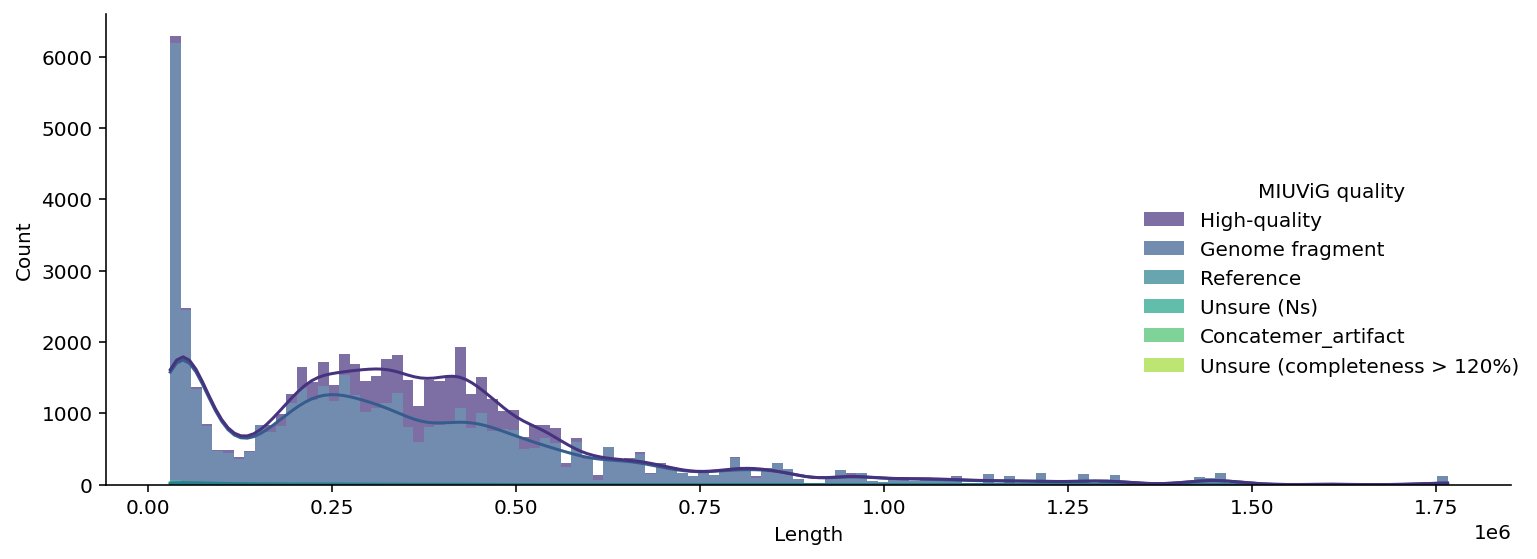

In [6]:
fraglength = 3000

g = seaborn.displot( data=ncldvs[ ncldvs['Length'] > fraglength*min_aln ],
                     x='Length', hue='MIUViG quality',
                     kind='hist', kde=True, multiple='stack',
                     palette='viridis', alpha=0.7,
                     linewidth=0, height=4, aspect=2 )

tight_layout()

Extract contigs from Nucleocytoviricota genomes from IMG/VR v3 and write them to
separate FASTA files under `genome/`

In [103]:
contigs = set( ncldvs['Contig'] )

p = pyprind.ProgBar( dfm.shape[0], 'Extracting and writing Nucleocytoviricota contigs...' )    
with gzip.open( '/global/dna/dm_archive/mep/analyses/AUTO-300263/IMGVR_all_nucleotides.fna.gz', 'rt' ) as fin :
    for n,rec in enumerate( SeqIO.parse( fin, 'fasta' ) ) :
        p.update()
        if rec.id in contigs :
            i,row = next( ncldvs[ ncldvs.Contig == rec.id ].iterrows() )
            if row['coordinates'] == 'whole' :
                start,stop = 0, len(rec)
            else :
                start,stop = [ int(i) for i in row['coordinates'].split('-') ]
            with open( row['filename'], 'a' ) as fout :
                fout.write( rec[start:stop].format('fasta') )

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:41:56


In [5]:
with open( 'genomefiles.txt', 'w' ) as f :
    for name in set( ncldvs.filename ) :
        f.write( name + '\n' )

Run `fastANI` 

**checkpoint 1** :

In [7]:
header = ['query', 'reference', 'ANI', 'bidirectional fragment mappings', 'total query fragments' ]
fastani = pandas.read_csv( 'ncldvs_vs_ncldvs_fastani.txt', sep='\t', names=header )

# drop self-hits
fastani = fastani[ fastani['query'] != fastani['reference'] ]

# de-duplicate (i.e., take the lower triangle of the matrix)
fastani['hash'] = fastani.apply( lambda row : hash( tuple( sorted( ( row['query'], row['reference'] ) ) ) ), axis=1 )
fastani.drop_duplicates( subset='hash', keep='first', inplace=True )
fastani.drop( ['hash'], axis=1, inplace=True )

# append genome lengths
filenames_to_bp = { d['filename'] : d['Length'] for d in ncldvs.loc[:,[ 'filename', 'Length' ]].to_dict( orient='records' ) }
fastani.insert( fastani.shape[1], 'qlen', fastani['query'].map( filenames_to_bp ) )
fastani.insert( fastani.shape[1], 'rlen', fastani['reference'].map( filenames_to_bp ) )

# build mapping dictionaries for UViG taxonomic information
taxonomy = { t : { d['filename'] : d[t] for d in 
                   ncldvs[['filename', t]].to_dict(orient='records') }
             for t in [ 't0','t1','t2','t3','t4','t5','t6','t7' ] }

# merge query taxonomic information with ANI scores
for level,taxmap in taxonomy.items() :
    fastani[level] = fastani['query'].map( taxmap )
fastani.rename( columns={'t0':'qt0','t1':'qt1','t2':'qt2','t3':'qt3','t4':'qt4','t5':'qt5','t6':'qt6','t7':'qt7' },
                     inplace=True )

# merge reference taxonomic information with ANI scores table
for level,taxmap in taxonomy.items() :
    fastani[level] = fastani['reference'].map( taxmap )
fastani.rename( columns={'t0':'rt0','t1':'rt1','t2':'rt2','t3':'rt3','t4':'rt4','t5':'rt5','t6':'rt6','t7':'rt7' },
                     inplace=True )

# tag each ANI hit as between taxa, within taxa or unknownn
taxnames = {
    't0' : 'realm',
    't1' : 'kingdom',
    't2' : 'phylum',
    't3' : 'class',
    't4' : 'order',
    't5' : 'family',
    't6' : 'genus',
    't7' : 'species' }

def taxmapper( query_tax, ref_tax, level='t0' ) :
    if not query_tax : return 'unknown' 
    if not ref_tax : return 'unknown'
    if query_tax == ref_tax : return 'cis-' + taxnames[level]
    else : return 'trans-' + taxnames[level]

for level,taxmap in taxonomy.items() :
    fastani[level] = [ taxmapper( d['q'+level], d['r'+level], level=level ) for d in
                       fastani[['q'+level,'r'+level]].to_dict(orient='records') ]

fastani

,query,reference,ANI,bidirectional fragment mappings,total query fragments,qlen,rlen,qt0,qt1,qt2,...,rt6,rt7,t0,t1,t2,t3,t4,t5,t6,t7
1,genomes/IMGVR_UViG_3300023179_001414.fasta,genomes/IMGVR_UViG_GVMAG-M-3300024502-1_000001...,85.6077,2,3,9065,233813,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,,,cis-realm,cis-kingdom,cis-phylum,cis-class,unknown,unknown,unknown,unknown
2,genomes/IMGVR_UViG_3300023179_001414.fasta,genomes/IMGVR_UViG_GVMAG-M-3300009164-8_000001...,77.1834,1,3,9065,546494,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,,,cis-realm,cis-kingdom,cis-phylum,cis-class,unknown,unknown,unknown,unknown
3,genomes/IMGVR_UViG_3300023179_001414.fasta,genomes/IMGVR_UViG_GVMAG-M-3300012954-33_00000...,77.1834,1,3,9065,298944,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,,,cis-realm,cis-kingdom,cis-phylum,cis-class,unknown,unknown,unknown,unknown
4,genomes/IMGVR_UViG_3300023179_001414.fasta,genomes/IMGVR_UViG_GVMAG-M-3300017967-22_00000...,77.1834,1,3,9065,409197,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,,,cis-realm,cis-kingdom,cis-phylum,cis-class,unknown,unknown,unknown,unknown
5,genomes/IMGVR_UViG_3300023179_001414.fasta,genomes/IMGVR_UViG_3300028569_000011.fasta,74.8976,1,3,9065,127321,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,,,cis-realm,cis-kingdom,cis-phylum,cis-class,unknown,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27333870,genomes/IMGVR_UViG_3300020238_000039.fasta,genomes/IMGVR_UViG_3300023501_000267.fasta,74.7584,1,2,8872,7438,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,Prasinovirus,,cis-realm,cis-kingdom,cis-phylum,cis-class,cis-order,cis-family,cis-genus,unknown
27333871,genomes/IMGVR_UViG_3300020238_000039.fasta,genomes/IMGVR_UViG_3300022822_000361.fasta,74.7584,1,2,8872,6253,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,Prasinovirus,,cis-realm,cis-kingdom,cis-phylum,cis-class,cis-order,cis-family,cis-genus,unknown
27333882,genomes/IMGVR_UViG_3300020238_000039.fasta,genomes/IMGVR_UViG_3300022842_000305.fasta,74.7584,1,2,8872,5643,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,Prasinovirus,,cis-realm,cis-kingdom,cis-phylum,cis-class,cis-order,cis-family,cis-genus,unknown
27333883,genomes/IMGVR_UViG_3300020238_000039.fasta,genomes/IMGVR_UViG_3300031227_001598.fasta,74.7584,1,2,8872,8708,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,Prasinovirus,,cis-realm,cis-kingdom,cis-phylum,cis-class,cis-order,cis-family,cis-genus,unknown


In [8]:
fastani.to_csv( 'ncldvs_vs_ncldvs_fastani_taxonomy.tsv', sep='\t' )

In [6]:
fastani = pandas.read_csv( 'ncldvs_vs_ncldvs_fastani_taxonomy.tsv', sep='\t' )

/global/homes/r/ryneches/opt/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**checkpoint 2**

Plot the distribution of ANI scores.

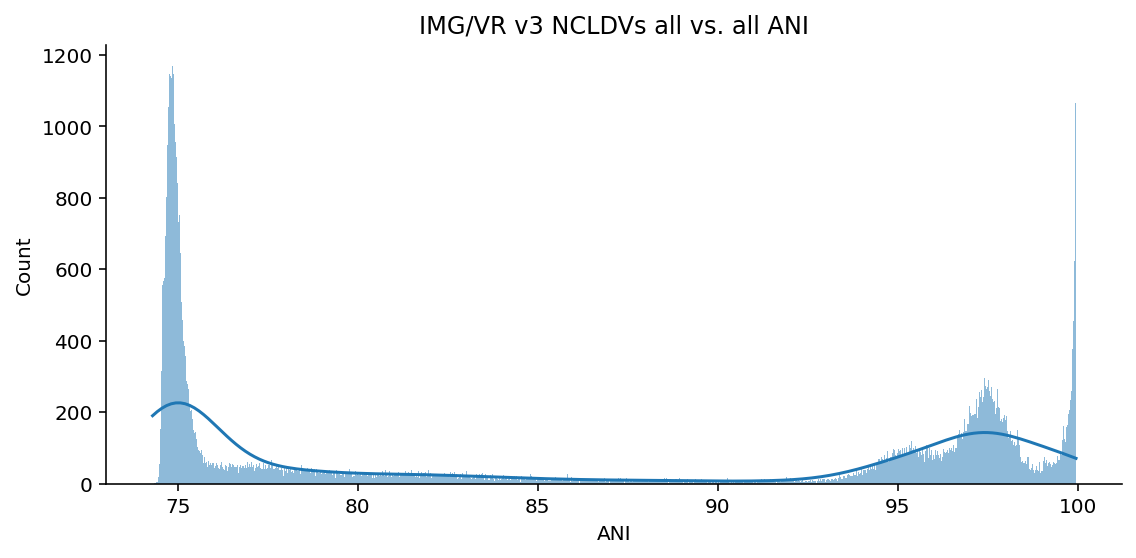

In [9]:
g = seaborn.displot( data=fastani[ ( fastani.ANI < max_ani )
                                 & ( fastani.ANI > 70 )
                                 & ( fastani['bidirectional fragment mappings'] > min_aln ) ],
                         x='ANI', kind='hist', kde=True, bins=1024,
                         fill=True, common_norm=False, palette='viridis', 
                         alpha=.5, linewidth=0, height=4, aspect=2)

title( 'IMG/VR v3 NCLDVs all vs. all ANI' )
tight_layout()
savefig( 'NCLDVs_all_vs_all_ani_alltaxa_hist.png', facecolor='white', dpi=200 )

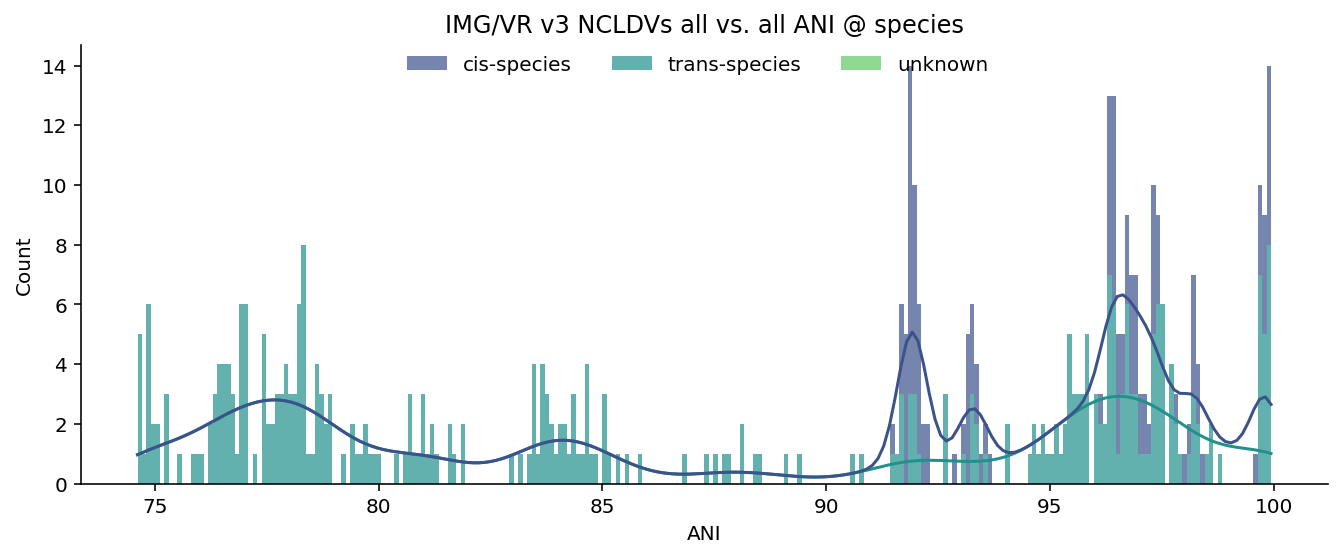

In [37]:
level='t7'

# tag each ANI hit as between taxa, within taxa or unknownn
taxnames = {
    't0' : 'realm',
    't1' : 'kingdom',
    't2' : 'phylum',
    't3' : 'class',
    't4' : 'order',
    't5' : 'family',
    't6' : 'genus',
    't7' : 'species' }

hue_order = sorted( set( fastani[level] ) )

g = seaborn.displot( data=fastani[ ( fastani.ANI < max_ani )
                                 & ( fastani.ANI > 70 )
                                 & ( fastani[level] != 'unknown' )
                                 & ( fastani['bidirectional fragment mappings'] > min_aln ) ],
                         x='ANI', kind='hist', kde=True, kde_kws={'bw_method':0.1}, bins=256,
                         fill=True, multiple='stack', common_norm=False, hue=level, 
                         hue_order=hue_order, palette='viridis',
                         alpha=0.7, linewidth=0, height=4, aspect=2 )

seaborn.move_legend( obj=g, loc='upper center', bbox_to_anchor=(0.52, 0.92), ncol=3, title=None )

#xlim([76,100])

title( 'IMG/VR v3 NCLDVs all vs. all ANI @ ' + taxnames[level] )
tight_layout()
savefig( 'NCLDVs_all_vs_all_ani_hist_' + taxnames[level] + '_stacked.png', facecolor='white', dpi=200 )
#semilogy()

In [34]:
fastani.rt0.value_counts()

Varidnaviria    17554937
Name: rt0, dtype: int64

In [ ]:
seaborn.displot( x=fastani['ANI'], y=(fastani['bidirectional fragment mappings'] * 3000) / fastani['qlen'], kind='kde' )

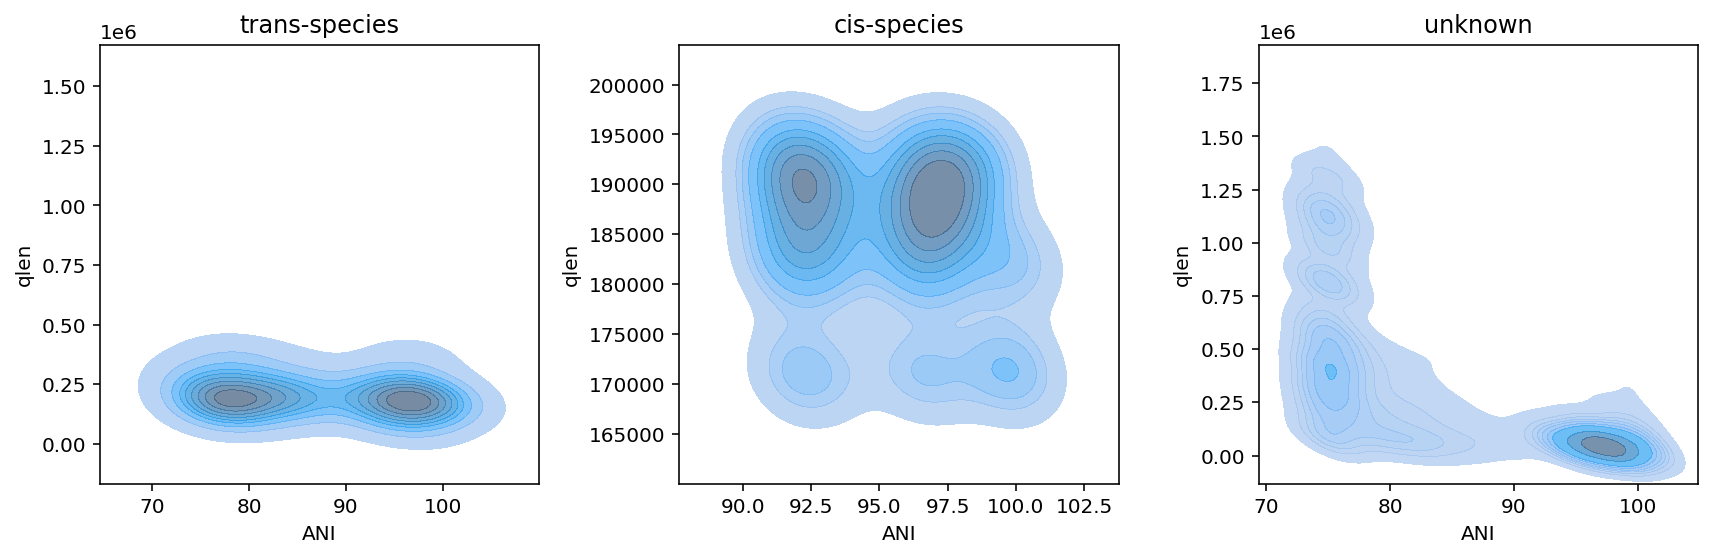

In [24]:
level = 't7'

figure( figsize=(12,4) )
for n,category in enumerate( set( fastani[level] ) ) :
    subplot( 1, 3, n+1 )
    g = seaborn.kdeplot( data=fastani[ ( fastani.ANI < max_ani )
                                     & ( fastani.ANI > 70 )
                                     & ( fastani[level] == category )
                                     & ( fastani['bidirectional fragment mappings'] > min_aln ) ],
                         x='ANI', y='qlen', fill=True, legend=False,
                         palette='viridis', alpha=0.7 )
    title( category )
    
tight_layout()

1+1

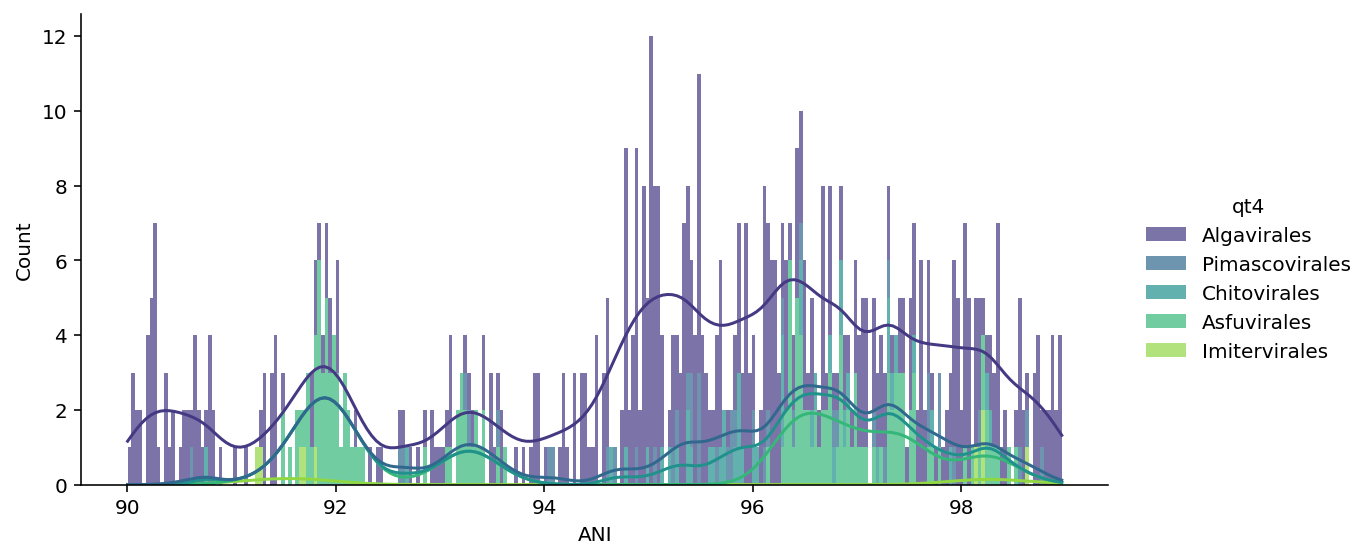

In [47]:
level = 't6'

#hue_order = sorted( set( fastani[ 'q' + taxnames[level] ] ) )

g = seaborn.displot( data=fastani[ ( fastani.ANI < 99 )
                                 & ( fastani.ANI > 90 )
                                 & ( fastani[level] == 'cis-' + taxnames[level] )
                                 & ( fastani['bidirectional fragment mappings'] > min_aln ) ],
                         x='ANI', kind='hist', kde=True, kde_kws={'bw_method':0.1}, bins=256,
                         fill=True, multiple='stack', common_norm=False, hue='qt4', 
                         palette='viridis', #hue_order=hue_order,
                         alpha=0.7, linewidth=0, height=4, aspect=2 )